<a href="https://colab.research.google.com/github/napoles-uach/ML-FCQ/blob/main/QML_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install qml --user -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 211 kB/s 
  Created wheel for qml: filename=qml-0.4.0.27-cp37-cp37m-linux_x86_64.whl size=1057024 sha256=381ee0924cfaa7965aa1746a137c9a8dd100d1ac6fb7680ac7d0e4fced3730ef
  Stored in directory: /root/.cache/pip/wheels/e4/6f/cc/cc6ed17565977d62aab6730e348c2e9d8c51c559896c467f74
Successfully built qml


# Se requiere reiniciar el entorno de ejecucion

In [1]:

from __future__ import print_function

import sys
print("Printing version info for help reporting bugs")
print("Python version:", sys.version)

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge

try:
    import qml
    from qml.kernels import gaussian_kernel
    from qml.kernels import laplacian_kernel
    from qml.math import cho_solve
    from qml.representations import get_slatm_mbtypes
    
    print("QML version:",qml.__version__)
except ImportError:
    print("Failed to find QML")
    print("Please follow instructions here: http://www.qmlcode.org/installation.html")

Printing version info for help reporting bugs
Python version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
QML version: 0.2.1


In [2]:
!git clone https://github.com/qmlcode/tutorial.git

Cloning into 'tutorial'...
remote: Enumerating objects: 7146, done.
remote: Total 7146 (delta 0), reused 0 (delta 0), pack-reused 7146
Receiving objects: 100% (7146/7146), 2.12 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [3]:
%cd tutorial

/content/tutorial


In [19]:
# Import QM7, already parsed to QML
from tutorial_data import compounds
from tutorial_data import energy_pbe0
# Assume 'qm7' is a list of Compound() objects.
mbtypes = get_slatm_mbtypes([mol.nuclear_charges for mol in compounds])


# For every compound generate a coulomb matrix or BoB
for mol in compounds: #can lower this if you need to via compounds[:1000] to just use first 1k molecules
    # you can select other descriptors here
    # full list here http://www.qmlcode.org/qml.html#module-qml.representations
    mol.generate_coulomb_matrix(size=23, sorting="row-norm")
    # mol.generate_slatm(mbtypes, local=False)
    # mol.generate_bob(size=23, asize={"O":3, "C":7, "N":3, "H":16, "S":1})

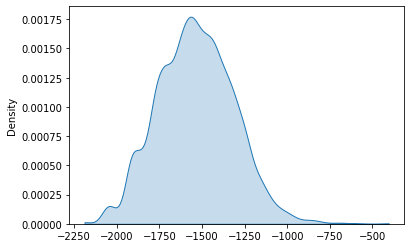

In [20]:
sns.kdeplot(energy_pbe0, shade=True, cut=0)

In [21]:
# observable we are trying to predict
y = energy_pbe0
# molecular descriptor from qml
X = np.array([mol.representation for mol in compounds]) 

# split our data into testing data and training data with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [22]:
# select the kernel you wish to use for fitting
# and any preprocessing can be done here
# I only introduce this approach so others can play with 
# different kernels as a learning exercise
# KRR shown here

sigma = 4000
gamma = 1.0/(2*sigma**2)
alpha = 1e-8
kernel = KernelRidge(gamma=gamma, kernel="rbf", alpha=alpha)


# find the fitting coeffecients
kernel.fit(X_train, y_train)

# and make predictions on test data
predictions = kernel.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


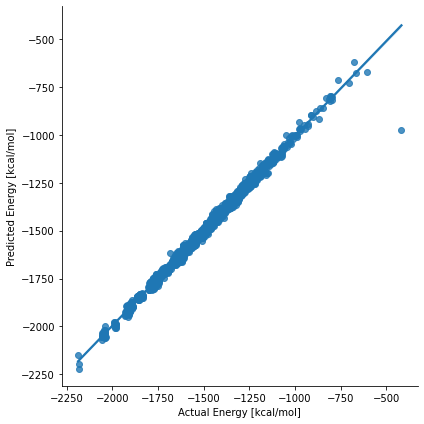

In [23]:
data=pd.DataFrame(data={'Actual Energy [kcal/mol]': y_test, 'Predicted Energy [kcal/mol]': predictions})
sns.lmplot(x="Actual Energy [kcal/mol]",y="Predicted Energy [kcal/mol]", truncate=True, data=data, size=6)

In [24]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions), "kcal/mol")
print('MSE:', metrics.mean_squared_error(y_test, predictions), "kcal/mol")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)), "kcal/mol")

MAE: 11.32736196645128 kcal/mol
MSE: 335.6555606953765 kcal/mol
RMSE: 18.320905018458465 kcal/mol
